# Simulate Neutron Scattering Data

> **_NOTE:_** This tutorial requires the installation of the [MJOLNIR package](https://mjolnir.readthedocs.io/). However, no data is required.

In this tutorial we will generate synthetic data in the exact same form as measured on the CAMEA instrumnet. We will utilize the case of measuring the magnetic dispersion of single crystal MnF$_2$ as described by [Yamany et al. 2010](https://www.doi.org/10.1139/P10-081). The synthetic data will consist of 12 sample rotation scans as measured on CAMEA. 

The dispersion relation of MnF$_2$ can be approximated analytically by:

$$\omega(H,K,L) = \sqrt{\left(2S z_2 J_2+D+2 z_1 S J_1 \sin{L \pi}^2\right)^2-\left(2 S z_2 J_2 \cos(H \pi)\cos(K \pi) \cos(L \pi)\right)^2}$$

In the above $J_1$, $J_2$, and $D$ are the magnetic coupling strengths and single-ion anisotropy which determine the amplitude of the dispersion. The parameters $S = 5/2$, $z_1 = 2$, and $z_2 = 8$ corresponds the the size of the magnetic spin, and the number of nearest and next-nearest neighbours in the MnF$_2$ lattice. 

From the above equation, the imporant fact is that it depends on the 3D vector $Q = (H,K,L)$. For the specfic crystal orientation, $(H,0,L)$ defines our scattering plane meaning $K$ is zero.

The instrument resolution/response function of CAMEA is not perfect and thus data acquired get smeard. For simplicy, this smearing will be approximated by a 1D Gaussian smearing along the energy direction.




In [1]:
import numpy as np
import matplotlib.pyplot as plt

from MJOLNIR.Data import DataSet, Sample, Mask, DataFile, BackgroundModel
from MJOLNIR import TasUBlibDEG
from MJOLNIR.Geometry import Instrument
import copy
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline


### Define needed functions for dispersion and SpinWave smearing

In [2]:
S = 5/2
z1 = 2
z2 = 8

def MnF2(Q,J1,J2,D):
    return np.sqrt(np.power(2*S*z2*J2+D+2*z1*S*J1*np.sin(Q[2,:]*np.pi)**2,2.0)-
            np.power(2*S*z2*J2*np.cos(Q[0]*np.pi)*np.cos(Q[1]*np.pi)*np.cos(Q[2]*np.pi),2.0))

def SpinWave(H,K,L,E):
    #ani = 1.2
    #amp = 0.5
    sigmaE = 0.25
    omega = MnF2(np.array([H,K,L]),  J1=0.0354,J2=0.1499,D=0.131 )
    I = np.exp(-np.power(omega-E,2.0)/(2*sigmaE**2))
    
    return I

## Generate CAMEA Data files

For this tutorial we will generate 12 data files with the following settings

- $E_i$ = 5, 5.13, 7, 7.13, 9, and 9.13 meV
- $2\theta$ = -40 and -44 deg
- $A_3$ range are [ -45 , 45 ] deg at 5 and 5.13 meV
- $A_3$ range are [ -37 , 37 ] deg at 7 and 7.13 meV
- $A_3$ range are [ -29 , 29 ] deg at 9 and 9.13 meV

The lattice parameters of MnF$_2$, needed to generate the correct scattering vectors are 

- $a$ = $b$ = 4.873 Å
- $\alpha$ = $\beta$ = $\gamma$ = 3.3107 deg

For the alignment of the sample, two peaks in the scattering plane (which is $(H,0,L)$) are needed. These are

- r1: [1,0,+1] at $A_3$ = 35.74 deg, $A_4$ = -95.21 deg, and incoming and outoging energy equal at $E_i$ = $E_f$ = 5.0 meV
- r2: [1,0,-1] at $A_3$ =-32.35 deg, $A_4$ = -95.21 deg, and incoming and outoging energy equal at $E_i$ = $E_f$ = 5.0 meV


In [3]:
dfs = [] # Container for generated DataFiles

for i,ei in enumerate([5,7,9]):
    df = DataFile.DataFile()

    # Define sample and initialize sample - All of this is MJOLNIR specific
    s = Sample.Sample(a=4.873,b=4.873,c=3.3107,alpha=90,beta=90,gamma=90)

    r1 = np.array([1.0,0.0,1.0,35.74,-95.21,0.0,0,0.0,5.0,5.0])
    r2 = np.array([-1.0,0,1.0,-32.35,-94.64,0.0,0,0.0,5.0,5.0])
    s.plane_vector1 = r1
    s.plane_vector2 = r2

    # Vectors defining the main axes
    s.projectionVector1 = np.array([1.0,0.0,0.0])
    s.projectionVector2 = np.array([0.0,0.0,1.0])
    s.planeNormal = np.asarray([0.0,1.0,0.0])

    s.plane_vector1 = np.delete(s.plane_vector1,3)
    s.plane_vector1[5:7] = 0.0
    s.plane_vector2 = np.delete(s.plane_vector2,3)
    s.plane_vector2[5:7] = 0.0
    s.orientationMatrix = TasUBlibDEG.calcTasUBFromTwoReflections(s.cell, s.plane_vector1, s.plane_vector2)

    s.initialize()
    s.calculateProjections()

    s.UB = s.orientationMatrix

    # Start to populate the parameters for the data file
    df.A3 = np.linspace(-45-8*i,45-8*i,91)
    df.A4 = np.asarray([-40])
    df.Ei = np.asarray([ei])
    df.Monitor = np.asarray([125000]*len(df.A3))
    df.fileLocation = None
    df.name = 'Test'

    
    df.I = np.zeros([len(df.A3),104,1024])
    df.sample = s

    # For simplicity, df2 is a deep copy of df1 with only the A4 value changed
    df2 = copy.deepcopy(df)
    df2.A4 = np.asarray([-44])

    df3 = copy.deepcopy(df)
    df3.Ei = np.asarray([ei+0.13])

    df4 = copy.deepcopy(df2)
    df4.Ei = np.asarray([ei+0.13])

    dfs.append(df)
    dfs.append(df2)
    
    dfs.append(df3)
    dfs.append(df4)

# Collect all of the 12 data files into a DataSet
ds = DataSet.DataSet(dfs)

# Convert utilizing the standard binning 8
ds.convertDataFile(binning=8)

# To allow a comparison between treated and ground truth data, a compy of the initial DataSet is made
ds_calculated = copy.deepcopy(ds)


### Addition of noise and background
As described in the documentation, AMBER expects the background signal to be smoothly varying in all 3 directions as well as to be independent of rotations around the origin, i.e. $(0,0,0)$. In the following, such a background, mimicing real world background, is generated and added to the intensity in the DataFiles. In addition, due to the Poisson nature of counting statistics, which neutron scattering falls under, the final neutron count will be found from the calcualted intensity subject to Poisson noice

In [4]:

def A4BG(a4,A):
    gamma = 10
    return 2*A*((gamma/(a4**2+gamma**2))+0.02*np.exp(-np.power(a4+120,2.0)/(2*20**2)))

# Containers to retain the different contributions
trueForeground = []
trueRandomBackground  = []
trueA3IndependentBackground = []

for d,d_calcualted in zip(ds,ds_calculated):
    trueForeground.append(np.round(SpinWave(d.h,d.k,d.l,d.energy)*(d.Monitor*d.Norm)))
    trueRandomBackground.append(np.ones(d.I.shape)*0.01)
    trueA3IndependentBackground.append(A4BG(d.instrumentCalibrationA4+d.A4,A=50*10).reshape(1,104,64))
    d.I =np.random.poisson(trueForeground[-1])
    d.I+=np.random.poisson(trueRandomBackground[-1]) # constant Background
    d.I+=np.random.poisson(trueA3IndependentBackground[-1])

    d_calcualted.I =np.random.poisson(trueForeground[-1])

## Utilizing some MJOLNIR features to showcase the data
Following are a couple of plots of the data using MJOLNIR functions

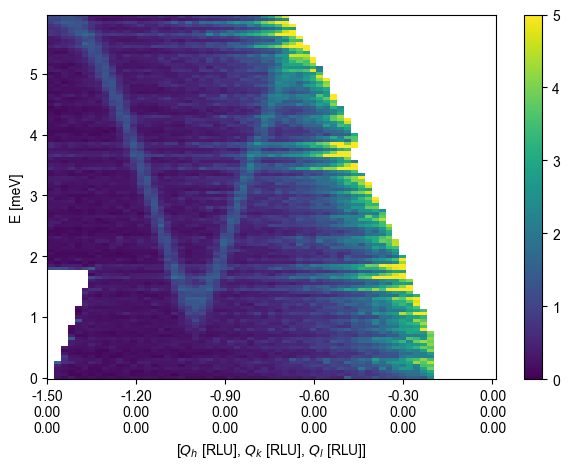

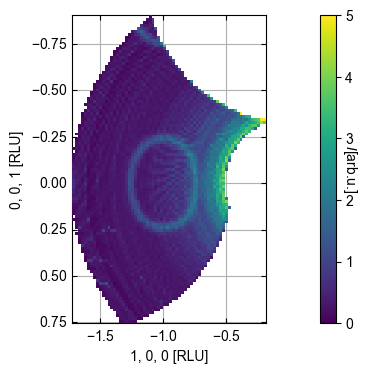

In [5]:
%matplotlib inline

# Generate 2D cut in momentum transfer and energy
q1 = np.array([-1.5, 0.0, 0]) # r.l.u.
q2 = np.array([0, 0.0, 0.0]) # r.l.u.
EMin = 0.0 # meV
EMax = 6.0 # meV
dE = 0.05 # meV
width = 0.03 # 1/Å orthogonal to cutting direction
minPixel = 0.03 # 1/Å bin size along cutting direction

ax, *d = ds.plotCutQE(q1=q1, q2=q2, EMin=EMin, EMax=EMax, dE = dE, 
                     width=width, minPixel=minPixel, vmin=0.0, vmax=5,
                    colorbar = True)

# Generate a constant energy cut
EMin = 4.5 # meV
EMax = 4.55 # meV
dqx = 0.03 # 1/Å bin size
dqy = 0.03 # 1/Å bin size


ax, *d = ds.plotQPlane(EMin=EMin,EMax=EMax, xBinTolerance=dqx, yBinTolerance=dqy, 
                        vmin=0.0, vmax=5,colorbar = True)

## Initialize AMBER background

In [6]:
AB = BackgroundModel.AMBERBackground(ds,dQx = 0.03, dQy = 0.03, dE = 0.05, beta=100)
AB.set_radial_bins()

C:\Anaconda\envs\python311\Lib\site-packages\MJOLNIR\Data\BackgroundModel.py:309: RuntimeWarning: invalid value encountered in divide
  self.I = np.divide(self.data[0] * self.data[-1], self.data[1] * self.data[2])


## Minimize RMSQ for beta

> **_NOTE:_** Running the cross-normalization will take quite some time. > 5-10 minutes!

To perform a cross validation of the $\beta$ value, on needs to set the qantile level where only background is left. That is, byt masking out higher intensity regions one can assume that the original minimization problem only contain the data and the background, i.e.

$
\min_{X,b} \frac{1}{2}\lVert Y-X-\mathcal{R}b\rVert_{2}^2+\lambda\vert| X |\vert_{1} +\frac{\beta}{2} \mathrm{Tr} \left( b^T L_{b} b \right) +\frac{\mu}{2} \boldsymbol{1}_{n_x}^TX^T L_{\omega} X\boldsymbol{1}_{n_y}
$

becomes

$
\min_{b} \frac{1}{2}\lVert Y-\mathcal{R}b\rVert_{2}^2+\frac{\beta}{2} \mathrm{Tr} \left( b^T L_{b} b \right) 
$

For the above data set, a value of 0.75 (the default setting) is suitable. 

### Minimization methods

One can do two things to find the optimal $\beta$ value

1. Calculate the RMSE across multiple decades and interpolate
2. Perform a minimization


It is adviced to first perform a coarse calculation for then to perform the minimization as the latter can be quite time-consuming.

In [9]:
# We define a list of reasonable beta values distributed over 3 orders of magnitude

beta = [1,3,7,10,30,70,100,300,700,1000]
RMSE = AB.cross_validation(q=0.75, beta = beta,verbose=False,n_epochs=20)

q=0.75, beta=array([   1,    3,    7,   10,   30,   70,  100,  300,  700, 1000]), l=0.2665642114325497, mu=0.2427590851339083, n_epochs=20, verbose=False
Test - ( 1 )
RMSE - ( 0.2665642114325497 1 0.2427590851339083 ) :  0.10329160145964443
Test - ( 3 )
RMSE - ( 0.2665642114325497 3 0.2427590851339083 ) :  0.1028468402733826
Test - ( 7 )
RMSE - ( 0.2665642114325497 7 0.2427590851339083 ) :  0.10225770010882033
Test - ( 10 )
RMSE - ( 0.2665642114325497 10 0.2427590851339083 ) :  0.1019720100920882
Test - ( 30 )
RMSE - ( 0.2665642114325497 30 0.2427590851339083 ) :  0.10156595368428951
Test - ( 70 )
RMSE - ( 0.2665642114325497 70 0.2427590851339083 ) :  0.10227250242411776
Test - ( 100 )
RMSE - ( 0.2665642114325497 100 0.2427590851339083 ) :  0.10292055384172495
Test - ( 300 )
RMSE - ( 0.2665642114325497 300 0.2427590851339083 ) :  0.10781518872596527
Test - ( 700 )
RMSE - ( 0.2665642114325497 700 0.2427590851339083 ) :  0.11480259052941344
Test - ( 1000 )
RMSE - ( 0.2665642114325497 100

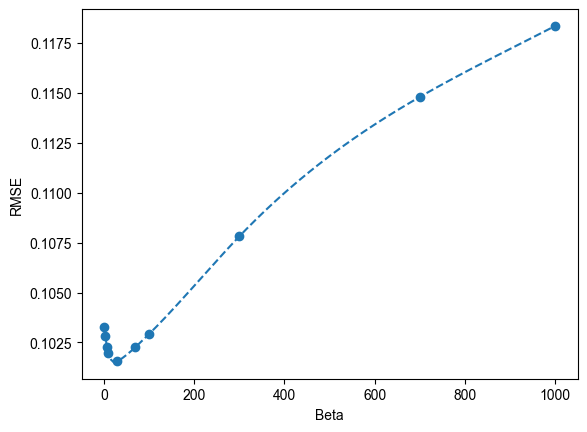

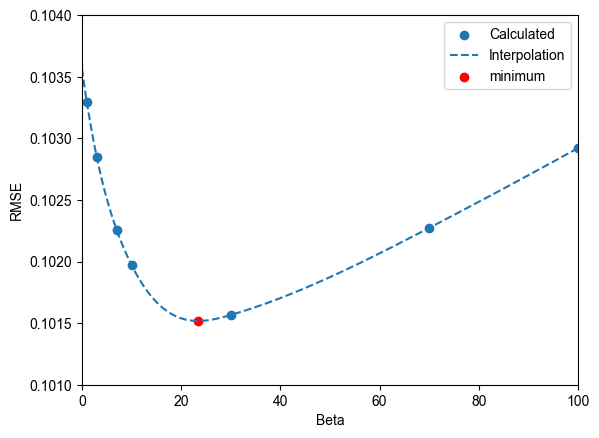

In [27]:
# As a guide to the eye, a Cubic Spline will be added

interpolation = CubicSpline(np.asarray(beta),RMSE)
x = np.linspace(np.min(beta),np.max(beta),201)
y = interpolation(x)

fig,ax = plt.subplots()

ax.scatter(beta,RMSE,label='Calculated')
ax.plot(x,y,'--',label='Interpolation')

ax.set_xlabel('Beta')
ax.set_ylabel('RMSE')


x2 = np.linspace(0,100,501)
y2 = interpolation(x2)

xmin,ymin = x2[np.argmin(y2)],y2[np.argmin(y2)]

fig,ax = plt.subplots()
ax.scatter(beta,RMSE,label='Calculated')
ax.plot(x2,y2,'--',label='Interpolation')
ax.scatter(xmin,ymin,label='minimum',color='r')

ax.set_xlabel('Beta')
ax.set_ylabel('RMSE')
ax.set_xlim(0,100)
ax.set_ylim(0.1010,0.1040)
ax.legend()

In [ ]:
# If the above has been run, utilize that value otherwise set ymin to 23.4

xmin = 23.4

func = lambda beta: AB.cross_validation(q=0.75, beta = beta,verbose=False,n_epochs=20)

result = minimize(func,x0 = [xmin])


## Generation of AMBER background

In [30]:
AB.beta = xmin

In [40]:
AB.generateAMBER(n_epochs=25)
AB.applyAMBER()

 Iteration  1
 Loss function:  89216.17289327279
 Iteration  2
 Loss function:  68093.90388265462
 Iteration  3
 Loss function:  57929.508628268115
 Iteration  4
 Loss function:  51147.228477046934
 Iteration  5
 Loss function:  46560.03500671341
 Iteration  6
 Loss function:  43283.23323431091
 Iteration  7
 Loss function:  40937.53702364261
 Iteration  8
 Loss function:  39308.08183709762
 Iteration  9
 Loss function:  38236.35126931614
 Iteration  10
 Loss function:  37568.299703508696
 Iteration  11
 Loss function:  37178.28929735461
 Iteration  12
 Loss function:  36963.03718997033
 Iteration  13
 Loss function:  36850.84062922201
 Iteration  14
 Loss function:  36796.66347072205
 Iteration  15
 Loss function:  36772.34667854443
 Iteration  16
 Loss function:  36761.725670802814
 Iteration  17
 Loss function:  36757.366819518116
 Iteration  18
 Loss function:  36755.782935800766
 Iteration  19
 Loss function:  36755.3751834626
 Iteration  20
 Loss function:  36755.43029325381
 Ite

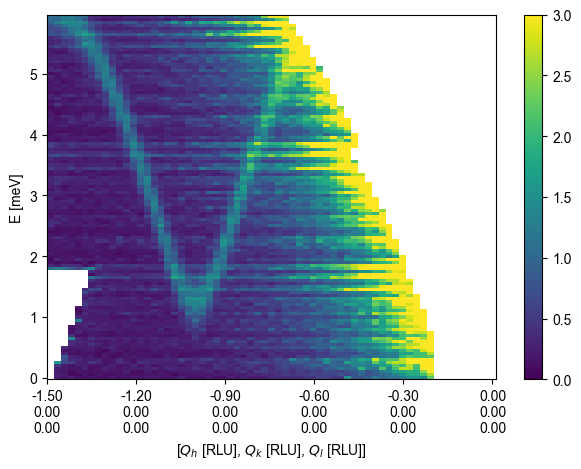

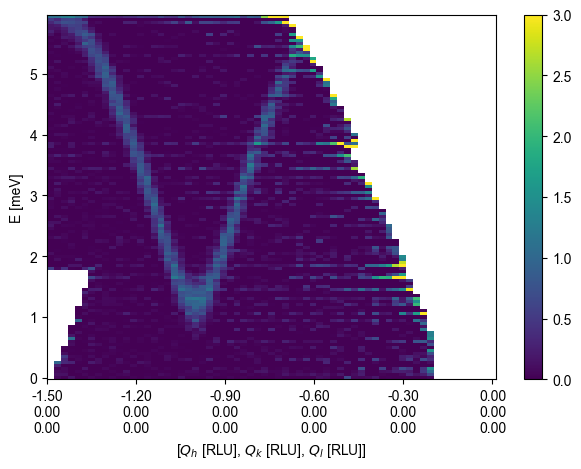

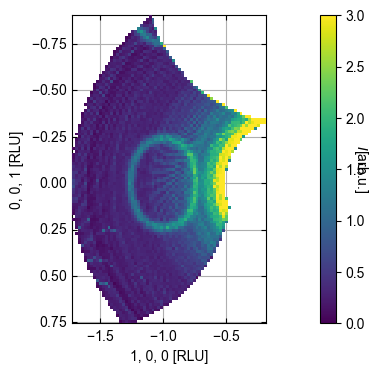

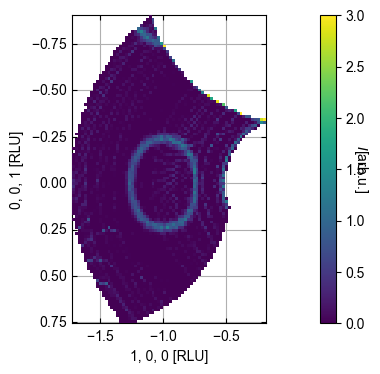

In [35]:
%matplotlib inline

# Generate 2D cut in momentum transfer and energy
q1 = np.array([-1.5, 0.0, 0]) # r.l.u.
q2 = np.array([0, 0.0, 0.0]) # r.l.u.
EMin = 0.0 # meV
EMax = 6.0 # meV
dE = 0.05 # meV
width = 0.03 # 1/Å orthogonal to cutting direction
minPixel = 0.03 # 1/Å bin size along cutting direction

ax, *d = ds.plotCutQE(q1=q1, q2=q2, EMin=EMin, EMax=EMax, dE = dE, 
                     width=width, minPixel=minPixel, vmin=0.0, vmax=3,
                    colorbar = True, backgroundSubtraction=False)

ax, *d = ds.plotCutQE(q1=q1, q2=q2, EMin=EMin, EMax=EMax, dE = dE, 
                     width=width, minPixel=minPixel, vmin=0.0, vmax=3,
                    colorbar = True, backgroundSubtraction=True)

# Generate a constant energy cut
EMin = 4.5 # meV
EMax = 4.55 # meV
dqx = 0.03 # 1/Å bin size
dqy = 0.03 # 1/Å bin size


ax, *d = ds.plotQPlane(EMin=EMin,EMax=EMax, xBinTolerance=dqx, yBinTolerance=dqy, 
                        vmin=0.0, vmax=3,colorbar = True, backgroundSubtraction=False)
ax, *d = ds.plotQPlane(EMin=EMin,EMax=EMax, xBinTolerance=dqx, yBinTolerance=dqy, 
                        vmin=0.0, vmax=3,colorbar = True, backgroundSubtraction=True)

### Create 1D cuts with overplotting

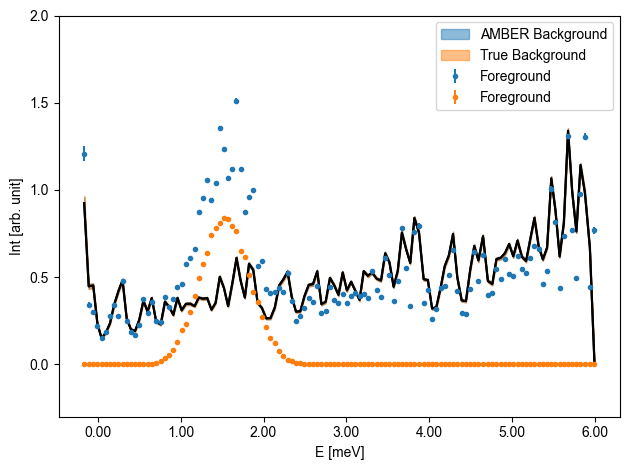

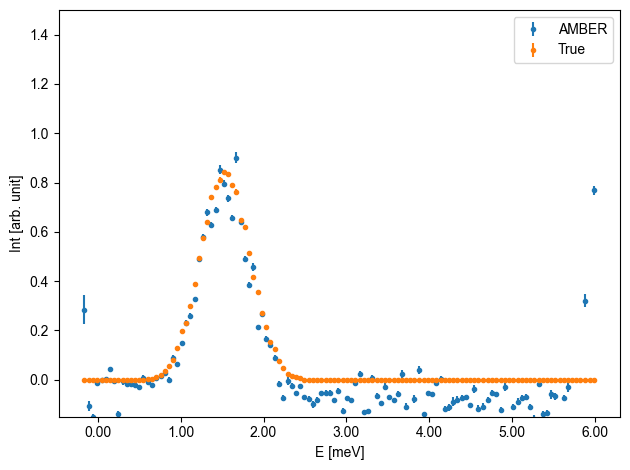

In [36]:
Q1 = np.array([-1.0, 0, 0])

ax1D001 = DataSet.generate1DAxisE(Q1,rlu=True,showQ = False)
ax1D001SUB = DataSet.generate1DAxisE(Q1,rlu=True,showQ = False)

titles = ["AMBER","True"]
fgDone = False



for dds,title in zip([ds,ds_calculated],titles): 
    
    
    #title = bg*'Subtracted'+(1-bg)*'Foreground'#'['+', '.join(['{:.0f}'.format(x) for x in q])+'] '+bg*'Subtracted'
    if dds == ds_calculated:
        ax,data,bins = dds.plotCut1DE(q=Q1, E1 = -0.2, E2 =7.0, width = 0.1, minPixel=0.05,label='Subtracted',ax=None)#,backgroundSubtraction=Fal,plotForeground=True)
    else:
        ax,data,bins = dds.plotCut1DE(q=Q1, E1 = -0.2, E2 =7.0, width = 0.1, minPixel=0.05,label='Subtracted',ax=None,backgroundSubtraction=True,plotForeground=True)

    plt.close(ax.get_figure())
    
    pos = data['BinDistance'].to_numpy()

    if dds != ds_calculated:
        bgvalue = data['Int_Bg'].to_numpy()
        bgerr = data['Int_Bg_err'].to_numpy()
        fgvalue = data['Int_Fg'].to_numpy()
        fgerr = data['Int_Fg_err'].to_numpy()
        subvalue = data['Int'].to_numpy()
        suberr = data['Int_err'].to_numpy()
    else:
        fgvalue = data['Int']
        fgerr = data['Int_err']
        subvalue = fgvalue
        suberr = fgerr
        

    #if not fgDone:
    ax1D001.errorbar(pos,fgvalue,yerr=fgerr,label='Foreground',fmt='.')
    #    fgDone = True
                     
    c = ax1D001SUB.errorbar(pos,subvalue,yerr=suberr,label=title,fmt='.')[0]
    color = c.get_color()
    
    ax1D001.plot(pos,bgvalue,color='k',zorder=-10)
    ax1D001.fill_between(pos,bgvalue-bgerr,bgvalue+bgerr,color=color,label=title+' Background',alpha=0.5,zorder=-11)

for ax in [ax1D001]:
    ax.set_ylim(-0.3,2)
    ax.legend()
    
    ax.set_ylabel('Int [arb. unit]')
    ax.get_figure().tight_layout()
    
for ax in [ax1D001SUB]:
    ax.set_ylim(-0.15,1.5)
    ax.legend()
    ax.set_ylabel('Int [arb. unit]')
    ax.get_figure().tight_layout()